In [40]:
#Import all the libraries

import numpy as np
import heapq
import matplotlib.pyplot as plt
import scipy.stats as sts
import random




#Code modified from session 2.1 (M/G/1 queue), modified to include manager and more than one queue

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    timestamp : float
        The time at which the event should run.
    function : callable
        The function to call when running the event.
    args : tuple
        The positional arguments to pass to the function.
    kwargs : dict
        The keyword arguments to pass to the function.

    Methods
    -------
    __lt__(self, other)
        Compare two events based on their timestamp.
    run(self, schedule)
        Run the event by calling the function with the arguments and keyword


    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        your docstring
        Parameters
        ----------
        other
            <include your description here>
        
        Returns
        -------
        bool
            <include your description here>
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        your docstring
        Parameters
        ----------
        schedule
            <include your description here>
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
    now : float
        The time at which the last event was run.
    priority_queue : list
        The priority queue of events.

    Methods
    -------
    add_event_at(self, timestamp, function, *args, **kwargs)
        Add an event to the schedule at a specific time.
    add_event_after(self, interval, function, *args, **kwargs)
        Add an event to the schedule after a specific interval.
    next_event_time(self)
        Return the time at which the next event will run.
    run_next_event(self)
        Run the next event in the schedule.
    __repr__(self)
        Return a string representation of the schedule.
    print_events(self)
        Print the schedule and the events in the queue.


    '''
    
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        your docstring
        Parameters
        ----------
        <include your list and description here>
        
        Returns
        -------
        <include your list and description here>
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')
    
    def time(self):
        # Convert time from float to hours and minutes
        hours = int(self.now // 60)
        minutes = int(self.now % 60)
        return f'{str.zfill(str(hours), 2)}:{str.zfill(str(minutes), 2)}'

In [41]:

#Add a MGC class to simulate
class Queue_MGC:
    def __init__(self, service_distribution, manager, queue_id, log_events=True):
        self.queue_id = queue_id
        self.service_distribution = service_distribution
        self.manager = manager
        self.arrival_times = []
        self.waiting_times = []
        self.service_times = []
        self.queue_length = 0
        self.busy = False
        self.max_queue_length = 0
        self.log_events = log_events
    
    def __lt__(self, other):
        return self.queue_length < other.queue_length


    def add_customer(self, schedule):
        #add customer to the queue
        self.queue_length += 1
        self.max_queue_length = max(self.max_queue_length, self.queue_length)
        if self.log_events:
            print(
                f'{schedule.time()}: Add customer to queue {self.queue_id}  '
                f'Queue length: {self.queue_length}')

        self.arrival_times.append(schedule.now)
        #if the queue is not busy, start serving the customer
        if not self.busy:
            schedule.add_event_after(0, self.start_service)
        
    def start_service(self, schedule):
        #start serving the customer
        self.queue_length -= 1
        self.busy = True
        self.waiting_times.append(schedule.now - self.arrival_times.pop(0))
        if self.log_events:
            print(
                f'{schedule.time()}: Start serving customer in queue {self.queue_id}  '
                f'Queue length: {self.queue_length}')
        service_time = self.service_distribution.rvs()
        self.service_times.append(service_time)
        schedule.add_event_after(service_time, self.end_service)

    def end_service(self, schedule):
        #end serving the customer
        self.busy = False
        if self.log_events:
            print(
                f'{schedule.time()}: End serving customer in queue {self.queue_id}  '
                f'Queue length: {self.queue_length}')
        # Probability of the manager being called
        if self.queue_id != 'Manager' and random.random() < 0.05:
            schedule.add_event_after(0, self.manager.add_customer)
        #if there are more customers in the queue, start serving the next customer
        if self.queue_length > 0:
            schedule.add_event_after(0, self.start_service)

            
class Manager(Queue_MGC):
    def __init__(self, service_distribution, log_events=True):
        self.service_distribution = service_distribution
        self.arrival_times = []
        self.waiting_times = []
        self.service_times = []
        self.queue_length = 0
        self.queue_id = 'Manager'
        self.busy = False
        self.max_queue_length = 0
        self.log_events = log_events


#add the manager to teh grocery store class
class GroceryStore_MGC:
    def __init__(self, arrival_distribution, service_distribution, manager_distribution, queue_count, store_open = 540, store_close = 1200, log_events = True):
        self.manager = Manager(manager_distribution, log_events)
        if queue_count > 10:
            raise ValueError('The maximum number of queues is 10')
        self.queues = [Queue_MGC(service_distribution, self.manager, queue_id=i, log_events=log_events) for i in range(queue_count)]
        self.arrival_distribution = arrival_distribution
        self.store_open = store_open
        self.store_close = store_close
        self.log_events = log_events

    def open_store(self, schedule):
        if self.log_events:
            print(f'Store opens at {schedule.time()}')
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def close_store(self, schedule):
        if self.log_events:
            print(f'Store closes at {schedule.time()}')

    def add_customer(self, schedule):
        # Check if the store is still open
        if schedule.now >= self.store_close:
            schedule.add_event_after(0, self.close_store)
            return

        # Add this customer to the queue
        queue = min(self.queues)
        queue.add_customer(schedule)

        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the store opens 
        schedule.add_event_after(
            self.store_open,
            self.open_store)
        
        # Run the simulation
        while schedule.priority_queue:
            schedule.run_next_event()
        

def run_simulation(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events):
    schedule = Schedule()
    grocery_store = GroceryStore_MGC(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events=log_events)
    grocery_store.run(schedule)
    return grocery_store, schedule
        




In [42]:
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=1)
manager_distribution = sts.norm(loc=5, scale=2**0.5)
queue_count = 3
grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=True)
print(f'🧍🏾‍♀️ There are {[queue.queue_length for queue in grocery_store.queues]} people in the queue')
print(f'🧍🏾‍♀️ There are {grocery_store.manager.queue_length} people in the manager queue')
print(f'🧍🏾‍♀️ The average waiting time for the first queue is {np.mean(grocery_store.queues[0].waiting_times)}')
print(f'🧍🏾‍♀️ The average service time for the first queue is {np.mean(grocery_store.queues[0].service_times)}')
print(f'🧍🏾‍♀️ The average waiting time for the manager is {np.mean(grocery_store.manager.waiting_times)}')
print(f'🧍🏾‍♀️ The average service time for the manager is {np.mean(grocery_store.manager.service_times)}')



Store opens at 09:00
09:03: Add customer to queue 0  Queue length: 1
09:03: Start serving customer in queue 0  Queue length: 0
09:06: End serving customer in queue 0  Queue length: 0
09:06: Add customer to queue 0  Queue length: 1
09:06: Start serving customer in queue 0  Queue length: 0
09:06: Add customer to queue 0  Queue length: 1
09:07: Add customer to queue 1  Queue length: 1
09:07: Start serving customer in queue 1  Queue length: 0
09:10: Add customer to queue 1  Queue length: 1
09:10: End serving customer in queue 0  Queue length: 1
09:10: Start serving customer in queue 0  Queue length: 0
09:10: End serving customer in queue 1  Queue length: 1
09:10: Start serving customer in queue 1  Queue length: 0
09:10: Add customer to queue 0  Queue length: 1
09:10: Add customer to queue 1  Queue length: 1
09:12: Add customer to queue 2  Queue length: 1
09:12: Start serving customer in queue 2  Queue length: 0
09:12: End serving customer in queue 0  Queue length: 1
09:12: Start serving cu

100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


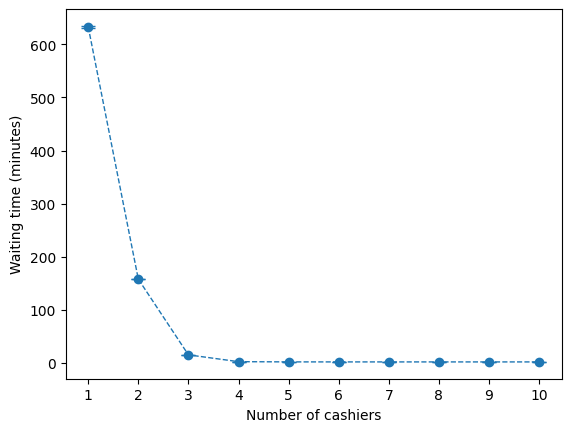

In [43]:
from tqdm import tqdm

cashiers = [i for i in range(1, 11)]
trials = 100

waiting_times_mean = []
waiting_times_std = []

for cashier_count in tqdm(cashiers):    
    waiting_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            waiting_times = waiting_times + queue.waiting_times
        waiting_times = waiting_times + grocery_store.manager.waiting_times
    waiting_times_mean.append(np.mean(waiting_times))
    waiting_times_std.append(sts.sem(waiting_times))

plt.errorbar(cashiers, waiting_times_mean, waiting_times_std, marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Waiting time (minutes)')
plt.show()
    





100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


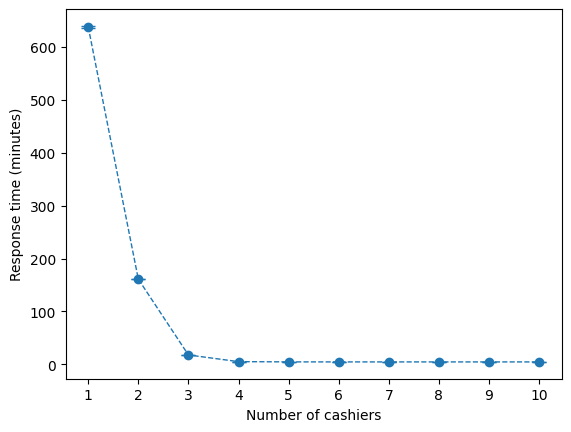

In [36]:
# Average customer response time, defined as the waiting time added by the service time.
# This is the metric we want to minimize.
response_times_mean = []
response_times_std = []

for cashier_count in tqdm(cashiers):
    response_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            response_times = response_times + [waiting_time + service_time for waiting_time, service_time in zip(queue.waiting_times, queue.service_times)]
        response_times = response_times + [waiting_time + service_time for waiting_time, service_time in zip(grocery_store.manager.waiting_times, grocery_store.manager.service_times)]
    response_times_mean.append(np.mean(response_times))
    response_times_std.append(sts.sem(response_times))

plt.errorbar(cashiers, response_times_mean, response_times_std, marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Response time (minutes)')
plt.show()



In [37]:
# Maximum queue length during a day, given the number of cashiers employed.
queue_lengths_mean = []
queue_lengths_std = []

for cashier_count in tqdm(cashiers):
    queue_lengths = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        queue_lengths.append(max([queue.max_queue_length for queue in grocery_store.queues]))
    queue_lengths_mean.append(np.mean(queue_lengths))
    queue_lengths_std.append(sts.sem(queue_lengths))

100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


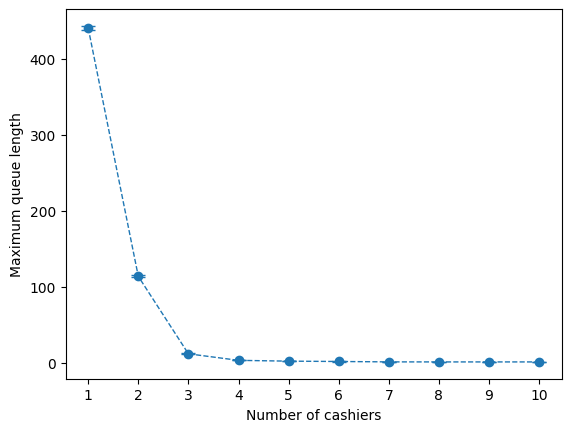

In [38]:
plt.errorbar(cashiers, queue_lengths_mean, queue_lengths_std, marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Maximum queue length')
plt.show()

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


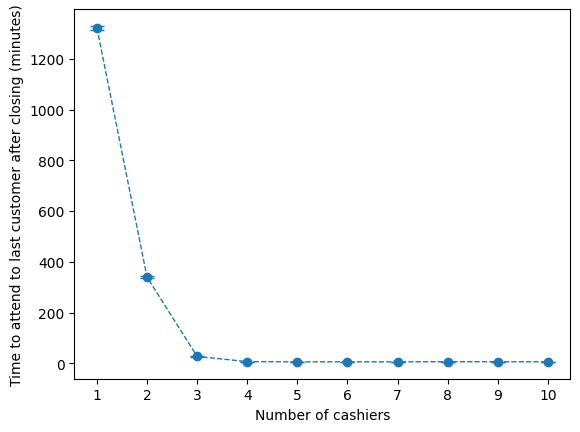

In [46]:
# Average time after the store closes till the last customer leaves.
# This is the metric we want to minimize.
last_customer_times_mean = []
last_customer_times_std = []

for cashier_count in tqdm(cashiers):
    last_customer_times = []
    for trial in range(trials):
        grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        last_customer_times.append(schedule.now - grocery_store.store_close)
    last_customer_times_mean.append(np.mean(last_customer_times))
    last_customer_times_std.append(sts.sem(last_customer_times))

plt.errorbar(cashiers, last_customer_times_mean, last_customer_times_std, marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Time to attend to last customer after closing (minutes)')
plt.show()